In [7]:
import numpy as np
import ducc0

def add_OofaNoise(tod, det, block_duration_s):
    
    n_block = int(block_duration_s * det.sampling_rate_hz)
    n_samp = tod.shape[1]
   
    # Create one OofaNoise generator per detector
    noise_gens = [
        ducc0.misc.OofaNoise(
            sigmawhite=det.net_ukrts * 1e-6 * np.sqrt(det.sampling_rate_hz),
            f_knee=det.fknee_mhz * 1e-3,
            f_min=det.fmin_hz,
            f_samp=det.sampling_rate_hz,
            slope=-det.alpha,
        )
        for _ in range(tod.shape[0])
    ]

    # Iterate through the entire TOD in blocks of n_block samples
    for start in range(0, n_samp, n_block):    # block start index
        end = min(start + n_block, n_samp)     # block end index
        block_len = end - start                # effective block length

        # Generate independent noise per detector
        for d in range(tod.shape[0]):
            white_chunk = np.random.normal(0., 1., block_len)               # Generates white noise
            tod[d, start:end] += noise_gens[d].filterGaussian(white_chunk)  # Adds 1/f filter to TOD in place (vector view, not copy)

            del white_chunk # Frees memory explicitly

    return tod

    
    """
    Add 1/f (Oofa) noise to time-ordered data (TOD) for one or more detectors.

    This function generates **independent 1/f noise** for each detector and processes
    the TOD in blocks to optimize memory usage. The noise is applied **in-place**,
    modifying the original TOD array. It is compatible with TOD arrays of shape (D, N),
    where D is the number of detectors and N is the number of time samples.

    Parameters
    ----------
    tod : numpy.ndarray
        2D array of shape (D, N) containing the time-ordered data to which noise will be added.
        Modifications are done in-place.
    det : litebird_sim.DetectorInfo
        Detector information object containing noise parameters:
        - sampling_rate_hz
        - fknee_mhz
        - fmin_hz
        - alpha
        - net_ukrts
        This implementation assumes all detectors share the same parameters.
    block_duration_s : float
        Duration of each processing block in seconds. The TOD is processed in blocks
        to reduce memory usage for long arrays.

    Returns
    -------
    numpy.ndarray
        The same `tod` array with added 1/f noise (modified in-place).
    """

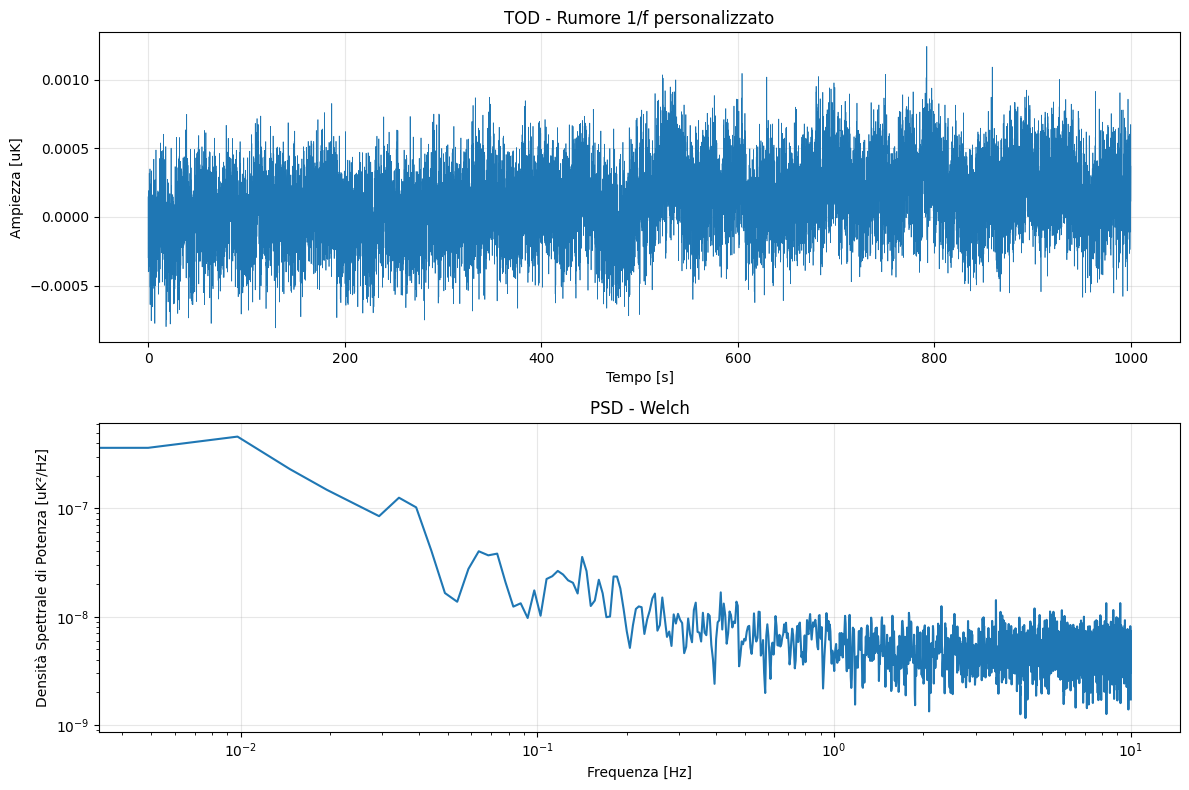

In [5]:
# MOCK DETECTOR

import litebird_sim as lbs
from astropy.time import Time
import numpy as np
from scipy.signal import welch
import matplotlib.pyplot as plt
import ducc0

start_time = 0
time_span_s = 1000.0
nside = 128

sim = lbs.Simulation(
    start_time=start_time,
    duration_s=time_span_s,
    random_seed=12345,
    imo=lbs.Imo(flatfile_location=lbs.PTEP_IMO_LOCATION) 
)

sim.set_scanning_strategy(
    lbs.SpinningScanningStrategy(
        spin_sun_angle_rad=np.deg2rad(0),
        precession_rate_hz=0,
        spin_rate_hz=1 / 60,
        start_time=start_time,
    ),
    delta_time_s=5.0,
)

sim.set_instrument(
    lbs.InstrumentInfo(
        boresight_rotangle_rad=0.0,
        spin_boresight_angle_rad=np.deg2rad(90),
        spin_rotangle_rad=np.deg2rad(75),
    )
)

det = lbs.DetectorInfo(
    name="Boresight_detector",
    sampling_rate_hz=20.,
    bandcenter_ghz=100.0,
    net_ukrts=50.0,
    fknee_mhz=500.,
    fmin_hz=1e-5,
    alpha=1
)


sim.create_observations(detectors=det)

# RUMORE
tod = sim.observations[0].tod 
add_OofaNoise(tod, det, block_duration_s=100) 


# Calcolo PSD con Welch
frequencies, psd = welch(
    tod,
    fs=det.sampling_rate_hz,           
    window='hann',            
    nperseg=2**12,            
    noverlap=2**12 // 2,       
    axis=-1,                 # calcola lungo l'asse dei campioni
    scaling='density',        
)




# Plot
plt.figure(figsize=(12, 8))

plt.subplot(2, 1, 1)
time_axis = np.arange(tod.shape[1]) / det.sampling_rate_hz
plt.plot(time_axis, tod[0], linewidth=0.5) # prendo il detector
plt.xlabel('Tempo [s]')
plt.ylabel('Ampiezza [uK]')
plt.title('TOD - Rumore 1/f personalizzato')
plt.grid(True, alpha=0.3)

plt.subplot(2, 1, 2)
plt.loglog(frequencies, psd[0], linewidth=1.5) # psd del primo detctor 
plt.xlabel('Frequenza [Hz]')
plt.ylabel('Densità Spettrale di Potenza [uK²/Hz]')
plt.title('PSD - Welch')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


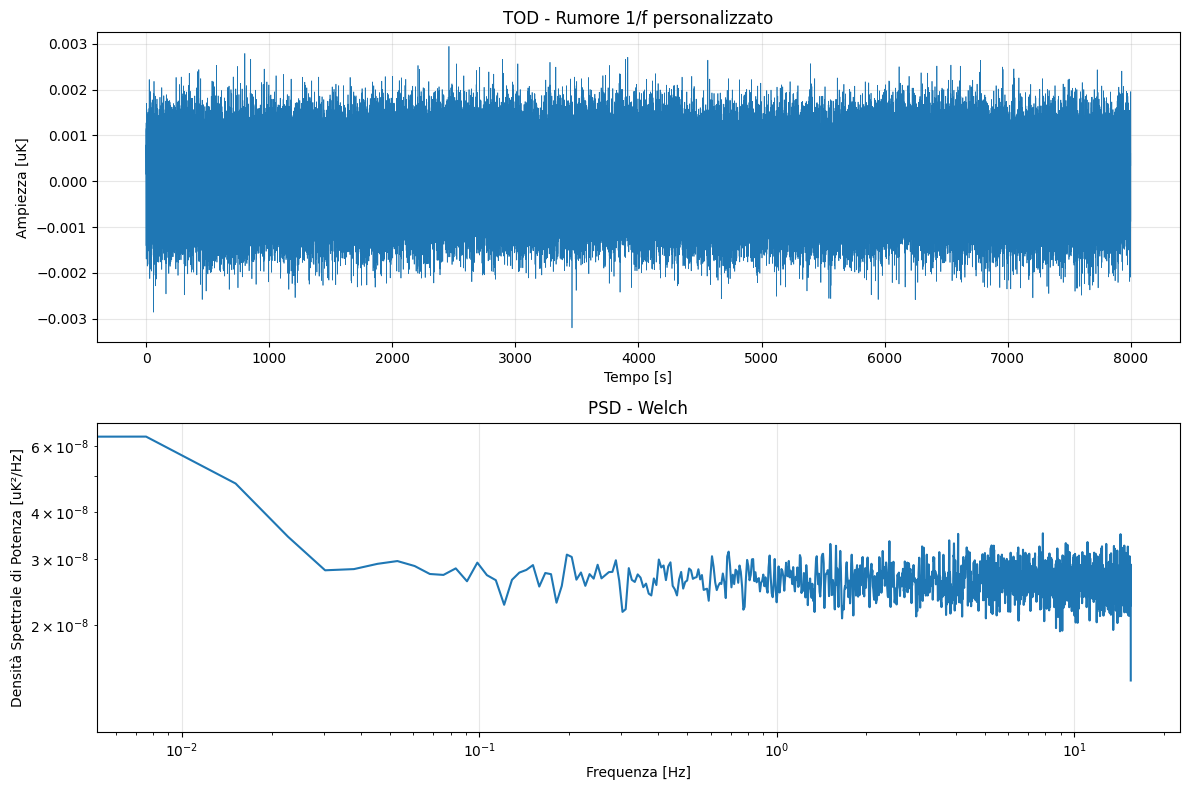


PARAMETRI DETECTOR
name                : 000_000_008_UA_040_T
sampling_rate_hz    : 31.0
bandcenter_ghz      : 40.0
net_ukrts           : 114.63
fknee_mhz           : 20.0
fmin_hz             : 1e-05
alpha               : 1.0


In [6]:
# IMO DETECTOR

import litebird_sim as lbs
from astropy.time import Time
import numpy as np
from scipy.signal import welch
import matplotlib.pyplot as plt
import ducc0

start_time = 0
time_span_s = 8000.0
nside = 128

imo = lbs.Imo(flatfile_location=lbs.PTEP_IMO_LOCATION) # Metto imo fuori

sim = lbs.Simulation(
    start_time=start_time,
    duration_s=time_span_s,
    random_seed=12345,
    imo=imo
)

sim.set_scanning_strategy(
    lbs.SpinningScanningStrategy(
        spin_sun_angle_rad=np.deg2rad(0),
        precession_rate_hz=0,
        spin_rate_hz=1 / 60,
        start_time=start_time,
    ),
    delta_time_s=5.0,
)

sim.set_instrument(
    lbs.InstrumentInfo(
        boresight_rotangle_rad=0.0,
        spin_boresight_angle_rad=np.deg2rad(90),
        spin_rotangle_rad=np.deg2rad(75),
    )
)

# carico dati reali detector
det = lbs.DetectorInfo.from_imo(imo, "/releases/vPTEP/satellite/LFT/L1-040/000_000_008_UA_040_T/detector_info")

sim.create_observations(detectors=det)


# RUMORE
tod = sim.observations[0].tod 
add_OofaNoise(tod, det, block_duration_s=1000) 


# Calcolo PSD con Welch
frequencies, psd = welch(
    tod,
    fs=det.sampling_rate_hz,           
    window='hann',            
    nperseg=2**12,            
    noverlap=2**12 // 2,       
    axis=-1,                 # calcola lungo l'asse dei campioni
    scaling='density',        
)




# Plot
plt.figure(figsize=(12, 8))

plt.subplot(2, 1, 1)
time_axis = np.arange(tod.shape[1]) / det.sampling_rate_hz
plt.plot(time_axis, tod[0], linewidth=0.5) # prendo il detector
plt.xlabel('Tempo [s]')
plt.ylabel('Ampiezza [uK]')
plt.title('TOD - Rumore 1/f personalizzato')
plt.grid(True, alpha=0.3)

plt.subplot(2, 1, 2)
plt.loglog(frequencies, psd[0], linewidth=1.5) # psd del primo detctor 
plt.xlabel('Frequenza [Hz]')
plt.ylabel('Densità Spettrale di Potenza [uK²/Hz]')
plt.title('PSD - Welch')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()



# Stampo parametri detector
print("\nPARAMETRI DETECTOR")

params = [
    "name",
    "sampling_rate_hz",
    "bandcenter_ghz",
    "net_ukrts",
    "fknee_mhz",
    "fmin_hz",
    "alpha"
]

for p in params:
    value = getattr(det, p)
    print(f"{p:20}: {value}")

### Function add_OofaNosie

→ Adds **1/f noise** to a detector’s **Time-Ordered Data (TOD)**, processing it **in blocks** to save memory.


#### Parameters

`tod` → Array containing the detector’s temporal data (Time Ordered Data). It will be **modified in place**.   
`det` → Detector configuration object (contains sampling rate, NET, etc.).   
`block_duration_s` → Duration of each processing block (seconds). Determines how much data is handled at once.   


####  Process Overview

1. Compute the total number of samples from duration and sampling rate.  
2. Initialize a **1/f noise generator** (`ducc0.misc.OofaNoise`).
3. Loop over the TOD **in consecutive blocks**:
   - Generate a block of white noise.
   - Filter it into 1/f noise.
   - Add it directly into the corresponding slice of `tod`.



#### How the loop works

Example:  
Suppose your TOD has 12 samples, and you choose blocks of 4 samples.
```
TOD before: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

Block 1 → [x, x, x, x]  
TOD after block 1 → [x, x, x, x, 0, 0, 0, 0, 0, 0, 0, 0]

Block 2 → [y, y, y, y]  
TOD after block 2 → [x, x, x, x, y, y, y, y, 0, 0, 0, 0]

Block 3 → [z, z, z, z]  
TOD after block 3 → [x, x, x, x, y, y, y, y, z, z, z, z]
```
Each block replaces the next segment of the TOD — no overlap, no copying.



#### Slice explanation

tod[start:end] += custom_chunk

- tod[start:end] selects a window (slice) of the TOD.
- It includes the element at index start, up to but not including end.
- The operator += modifies that part of the array in place.

Example:
```
TOD before: [0, 0, 0, 0, 0, 0]  
start = 2, end = 5  
custom_chunk = [0.1, -0.2, 0.05]  

Operation: tod[2:5] += custom_chunk  
TOD after: [0, 0, 0.1, -0.2, 0.05, 0]  
```

#### Conceptual illustration

Memory layout of TOD:  
```
[-----------------------------------------------------]
|---- Block 1 ----|---- Block 2 ----|---- Block 3 ----| 
```
Each iteration:
- creates a small noise block (temporary)
- writes it into the matching TOD region
- deletes the temporary arrays to free memory
